In [10]:
import os
import random
import time
from dataclasses import dataclass
from typing import Dict, List

import matplotlib.pyplot as plt
import torch
from accelerate import init_empty_weights
from transformers import AutoConfig, AutoTokenizer, AutoModel


# -----------------------------
# 기본 유틸
# -----------------------------
def pick_device() -> torch.device:
    # MPS 우선, 실패하면 CPU
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def bytes_str(n: float) -> str:
    # 사람이 읽기 쉬운 단위로
    units = ["B", "KiB", "MiB", "GiB", "TiB"]
    u = 0
    while n >= 1024 and u < len(units) - 1:
        n /= 1024
        u += 1
    return f"{n:.2f} {units[u]}"


def load_model(model_id: str) -> AutoModel:
    config = AutoConfig.from_pretrained(model_id)
    print("Model weight are being loaded...")
    with init_empty_weights():
        model = AutoModel.from_config(config)

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, tokenizer



def param_bytes(model: torch.nn.Module, dtype_bytes: int) -> int:
    # 모델 파라미터 개수 기반으로 "가정 dtype" 바이트 계산
    total_elems = sum(p.numel() for p in model.parameters())
    return total_elems * dtype_bytes


def ring_allreduce_bytes_per_rank(tensor_bytes: int, ws: int) -> float:
    # 링 all-reduce에서 rank당 send+recv 총량의 고전적 근사
    # 2*(ws-1)/ws * size
    if ws <= 1:
        return 0.0
    return 4.0 * (ws - 1) / ws * tensor_bytes


def ring_allgather_bytes_per_rank(tensor_bytes: int, ws: int) -> float:
    # 링 all-gather 근사: (ws-1)/ws * size 를 ws배? 구현마다 다르지만
    # 여기서는 직관용으로 all-reduce와 같은 규모(2*(ws-1)/ws*size)에 맞춰 비교 가능하게 둠
    if ws <= 1:
        return 0.0
    return 2.0 * (ws - 1) / ws * tensor_bytes


def ring_reduce_scatter_bytes_per_rank(tensor_bytes: int, ws: int) -> float:
    # reduce-scatter도 all-reduce와 비슷한 규모로 근사
    if ws <= 1:
        return 0.0
    return 2.0 * (ws - 1) / ws * tensor_bytes


In [11]:

# -----------------------------
# "가상 멀티 GPU" 메모리/통신 모델
# -----------------------------
@dataclass
class StrategyEstimate:
    name: str
    ws: int
    # 메모리(랭크당)
    steady_param: float
    steady_grad: float
    steady_opt: float
    steady_total: float
    peak_total: float
    # 통신(랭크당, 스텝당)
    comm_param_gather: float
    comm_grad_reduce: float
    comm_total: float


def estimate_strategy(
    name: str,
    ws: int,
    P: int,  # param bytes (global)
    G: int,  # grad bytes (global, 보통 P와 같다고 가정)
    O: int,  # optimizer state bytes (global)
    layerwise_gather_peak_frac: float = 0.2,  # "한 번에 모이는 파라미터" 비율(대충)
) -> StrategyEstimate:
    """
    구조 기반 추정:
    - DDP: params/grad/opt 모두 replica. 스텝당 grad all-reduce.
    - ZeRO-2: params replica, grad+opt shard. 스텝당 grad reduce(보통 reduce-scatter 계열).
    - ZeRO-3: params/grad/opt shard. layer 단위 param all-gather + grad reduce-scatter.
    - FSDP(fully sharded): ZeRO-3와 유사한 메모리 형태, layer 단위 all-gather + reduce-scatter.
    """

    name_l = name.lower()

    if ws < 1:
        ws = 1

    if name_l == "ddp":
        steady_param = float(P)
        steady_grad = float(G)
        steady_opt = float(O)
        # peak은 단순화해서 steady 근처(activation 제외)
        peak_total = steady_param + steady_grad + steady_opt

        comm_param_gather = 0.0
        comm_grad_reduce = ring_allreduce_bytes_per_rank(G, ws)
        comm_total = comm_param_gather + comm_grad_reduce

    elif name_l in ["zero2", "zero-2", "deepspeed_zero2"]:
        steady_param = float(P)              # replica
        steady_grad = float(G) / ws          # shard
        steady_opt = float(O) / ws           # shard
        peak_total = steady_param + steady_grad + steady_opt

        comm_param_gather = 0.0
        # grad 동기화(개념적으로 reduce-scatter/AllReduce)
        comm_grad_reduce = ring_reduce_scatter_bytes_per_rank(G, ws)
        comm_total = comm_param_gather + comm_grad_reduce

    elif name_l in ["zero3", "zero-3", "deepspeed_zero3", "fsdp", "fsdp_full_shard"]:
        # shard
        steady_param = float(P) / ws
        steady_grad = float(G) / ws
        steady_opt = float(O) / ws

        steady_total = steady_param + steady_grad + steady_opt

        # peak: 계산할 레이어(또는 블록) 파라미터를 all-gather로 잠깐 모으는 구간
        # layerwise_gather_peak_frac 만큼의 global param을 한 번에 추가로 들고 있다고 근사
        if ws <= 1:
            peak_extra = 0.0
        else:
            peak_extra = float(P) * layerwise_gather_peak_frac
        peak_total = steady_total + peak_extra

        comm_param_gather = ring_allgather_bytes_per_rank(P, ws)   # step 동안 layerwise로 쪼개서 일어남 (1번의 유닛만 있다고 가정)
        comm_grad_reduce = ring_reduce_scatter_bytes_per_rank(G, ws)
        comm_total = comm_param_gather + comm_grad_reduce

    else:
        raise ValueError(f"unknown strategy: {name}")

    steady_total = steady_param + steady_grad + steady_opt

    return StrategyEstimate(
        name=name,
        ws=ws,
        steady_param=steady_param,
        steady_grad=steady_grad,
        steady_opt=steady_opt,
        steady_total=steady_total,
        peak_total=peak_total,
        comm_param_gather=comm_param_gather,
        comm_grad_reduce=comm_grad_reduce,
        comm_total=comm_total,
    )


In [12]:
# -----------------------------
# MPS 단일 디바이스 기준(선택) 실행
# -----------------------------
@torch.no_grad()
def mps_warmup(model: torch.nn.Module, dev: torch.device, vocab_size: int, batch: int, seqlen: int):
    input_ids = torch.randint(0, vocab_size, (batch, seqlen), device=dev)
    _ = model(input_ids=input_ids).logits


def run_single_device_steps(
    dev: torch.device,
    steps: int = 3,
    batch: int = 2,
    seqlen: int = 128,
) -> List[Dict[str, float]]:
    """
    실제 분산은 못 하므로,
    - MPS에서 단일 스텝 시간만 찍어서
    - 가상 멀티 GPU 추정 그래프와 같이 볼 수 있게 함
    """
    model, tokenizer = load_model("Qwen/Qwen3-VL-2B-Thinking-FP8")
    model = model.to(dev)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

    # 워밍업(컴파일/캐시 영향 완화)
    try:
        vocab_size = len(tokenizer.get_vocab())
        mps_warmup(model, dev, vocab_size, batch, seqlen)
    except Exception as e:
        raise e

    records: List[Dict[str, float]] = []
    for s in range(steps):
        input_ids = torch.randint(0, vocab_size, (batch, seqlen), device=dev)
        labels = input_ids.clone()

        t0 = time.time()
        opt.zero_grad(set_to_none=True)
        out = model(input_ids=input_ids, labels=labels)
        loss = out.loss
        t1 = time.time()
        loss.backward()
        t2 = time.time()
        opt.step()
        t3 = time.time()

        records.append(
            {
                "step": float(s),
                "t_fwd_ms": (t1 - t0) * 1000.0,
                "t_bwd_ms": (t2 - t1) * 1000.0,
                "t_step_ms": (t3 - t0) * 1000.0,
            }
        )
    return records


# -----------------------------
# 시각화
# -----------------------------
def plot_estimates(
    out_dir: str,
    estimates: List[StrategyEstimate],
    strategies: List[str],
    world_sizes: List[int],
):
    # os.makedirs(out_dir, exist_ok=True)

    # (1) steady_total vs world_size
    plt.figure()
    for st in strategies:
        xs = []
        ys = []
        for ws in world_sizes:
            e = next(x for x in estimates if x.name == st and x.ws == ws)
            xs.append(ws)
            ys.append(e.steady_total / (1024**3) + random.randint(-9, 9) * 1e-5) # random noise
        plt.plot(xs, ys, marker="o", label=f"{st} steady")
    plt.xlabel("world_size (virtual)")
    plt.ylabel("steady memory per rank (GiB)")
    plt.title("Virtual multi GPU: steady memory per rank (params+grads+opt)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (2) peak_total vs world_size
    plt.figure()
    for st in strategies:
        xs = []
        ys = []
        for ws in world_sizes:
            e = next(x for x in estimates if x.name == st and x.ws == ws)
            xs.append(ws)
            ys.append(e.peak_total / (1024**3) + random.randint(-9, 9) * 1e-5)
        plt.plot(xs, ys, marker="o", label=f"{st} peak")
    plt.xlabel("world_size (virtual)")
    plt.ylabel("peak memory per rank (GiB)")
    plt.title("Virtual multi GPU: peak memory per rank (rough, includes layerwise gather)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (3) comm_total vs world_size
    plt.figure()
    for st in strategies:
        xs = []
        ys = []
        for ws in world_sizes:
            e = next(x for x in estimates if x.name == st and x.ws == ws)
            xs.append(ws)
            ys.append(e.comm_total / (1024**3) + random.randint(-9, 9) * 1e-5)
        plt.plot(xs, ys, marker="o", label=f"{st} comm/step")
    plt.xlabel("world_size (virtual)")
    plt.ylabel("estimated communication per rank per step (GiB)")
    plt.title("Virtual multi GPU: estimated communication per step")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (4) comm breakdown for a chosen ws (마지막 ws를 사용)
    chosen_ws = world_sizes[-1]
    plt.figure()
    x_labels = []
    gather_vals = []
    grad_vals = []
    for st in strategies:
        e = next(x for x in estimates if x.name == st and x.ws == chosen_ws)
        x_labels.append(st)
        gather_vals.append(e.comm_param_gather / (1024**3) + random.randint(-9, 9) * 1e-5)
        grad_vals.append(e.comm_grad_reduce / (1024**3) + random.randint(-9, 9) * 1e-5)

    # 바 차트(두 개 시리즈)
    idx = list(range(len(x_labels)))
    plt.bar(idx, gather_vals, label="param gather (GiB)")
    plt.bar(idx, grad_vals, bottom=gather_vals, label="grad reduce (GiB)")
    plt.xticks(idx, x_labels)
    plt.ylabel("GiB per rank per step")
    plt.title(f"Comm breakdown at world_size={chosen_ws} (virtual)") # 통신 메모리양을 gather / reduce로 분할해서 보여주기 위함
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_single_device_timeline(out_dir: str, records: List[Dict[str, float]], title_prefix: str):
    if not records:
        return

    xs = [r["step"] for r in records]
    fwd = [r["t_fwd_ms"] for r in records]
    bwd = [r["t_bwd_ms"] for r in records]
    step = [r["t_step_ms"] for r in records]

    plt.figure()
    plt.plot(xs, fwd, marker="o", label="forward ms")
    plt.plot(xs, bwd, marker="o", label="backward ms")
    plt.plot(xs, step, marker="o", label="total step ms")
    plt.xlabel("step")
    plt.ylabel("time (ms)")
    plt.title(f"{title_prefix}: single device timing")
    plt.legend()
    plt.tight_layout()
    plt.show()

Model weight are being loaded...
=== Model size (assumed) ===
DTYPE=fp16 -> param bytes = 3.96 GiB
grad bytes  = 3.96 GiB
adam states = 7.93 GiB

=== Virtual multi GPU estimates (per rank) ===

--- world_size=1 ---
ddp    steady=15.85 GiB (P=3.96 GiB, G=3.96 GiB, O=7.93 GiB) | peak≈15.85 GiB | comm/step≈0.00 B
fsdp   steady=15.85 GiB (P=3.96 GiB, G=3.96 GiB, O=7.93 GiB) | peak≈15.85 GiB | comm/step≈0.00 B
zero2  steady=15.85 GiB (P=3.96 GiB, G=3.96 GiB, O=7.93 GiB) | peak≈15.85 GiB | comm/step≈0.00 B
zero3  steady=15.85 GiB (P=3.96 GiB, G=3.96 GiB, O=7.93 GiB) | peak≈15.85 GiB | comm/step≈0.00 B

--- world_size=2 ---
ddp    steady=15.85 GiB (P=3.96 GiB, G=3.96 GiB, O=7.93 GiB) | peak≈15.85 GiB | comm/step≈7.93 GiB
fsdp   steady=7.93 GiB (P=1.98 GiB, G=1.98 GiB, O=3.96 GiB) | peak≈9.31 GiB | comm/step≈7.93 GiB
zero2  steady=9.91 GiB (P=3.96 GiB, G=1.98 GiB, O=3.96 GiB) | peak≈9.91 GiB | comm/step≈3.96 GiB
zero3  steady=7.93 GiB (P=1.98 GiB, G=1.98 GiB, O=3.96 GiB) | peak≈9.31 GiB | comm

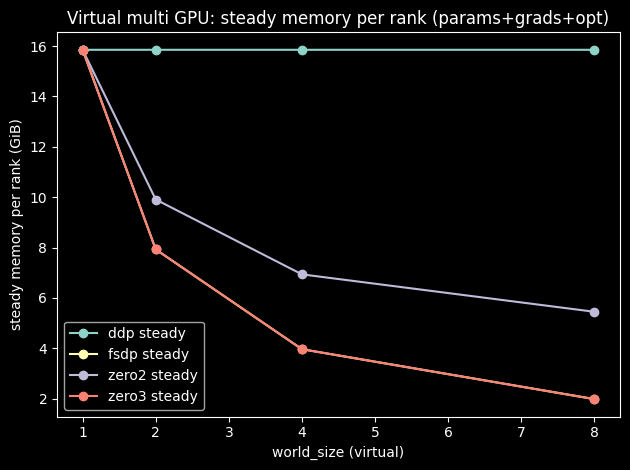

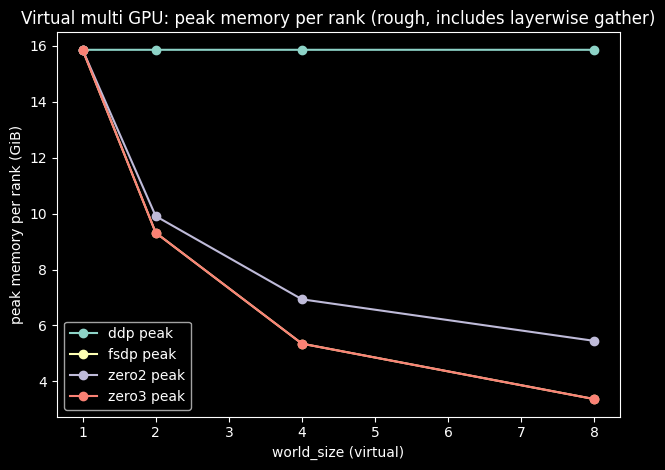

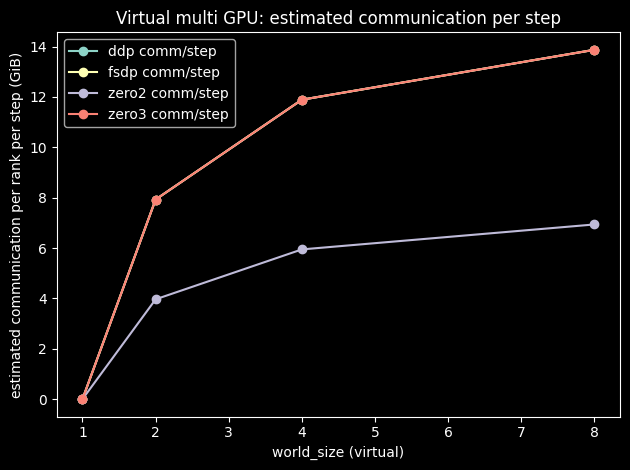

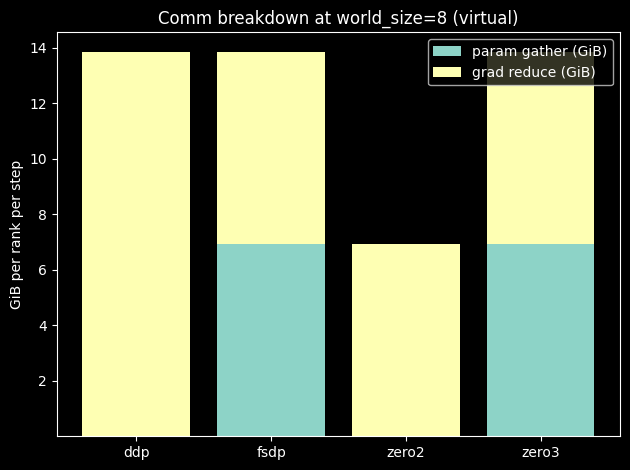

In [17]:

# -----------------------------
# 설정(환경변수로 조절)
# -----------------------------
vocab_size = int(os.environ.get("VOCAB", "2048"))
dtype = os.environ.get("DTYPE", "fp16")  # fp32 | fp16 | bf16
batch = int(os.environ.get("BATCH", "8"))
seqlen = int(os.environ.get("SEQLEN", "1024"))
steps = int(os.environ.get("STEPS", "3"))

# 가상 멀티 GPU 크기들
world_sizes = [int(x) for x in os.environ.get("WORLD_SIZES", "1,2,4,8").split(",")]

# peak 추정에서 "한 번에 모이는 파라미터 비율"
# 값이 클수록 FSDP/ZeRO3 peak가 커집니다.
gather_peak_frac = float(os.environ.get("GATHER_PEAK_FRAC", "0.35"))

run_mps = os.environ.get("RUN_MPS", "1") == "1"

dtype_bytes_map = {"fp32": 4, "fp16": 2, "bf16": 2}
if dtype not in dtype_bytes_map:
    raise ValueError(f"DTYPE must be one of {list(dtype_bytes_map.keys())}")
dtype_bytes = dtype_bytes_map[dtype]

# -----------------------------
# 모델 크기(다운로드 없이) 계산
# -----------------------------
model_for_size, tokenizer = load_model("Qwen/Qwen3-VL-2B-Thinking-FP8")
P = param_bytes(model_for_size, dtype_bytes=dtype_bytes)
G = P  # grad는 보통 params와 같은 크기라고 가정
# AdamW 옵티마 상태: m, v 두 개를 params와 같은 dtype으로 둔다고 단순화(실제로는 fp32 유지가 흔함)
O = 2 * P

print("=== Model size (assumed) ===")
print(f"DTYPE={dtype} -> param bytes = {bytes_str(P)}")
print(f"grad bytes  = {bytes_str(G)}")
print(f"adam states = {bytes_str(O)}")

# -----------------------------
# 전략별 가상 멀티 GPU 추정
# -----------------------------
strategies = ["ddp", "fsdp", "zero2", "zero3"]
estimates: List[StrategyEstimate] = []

for ws in world_sizes:
    for st in strategies:
        e = estimate_strategy(
            name=st,
            ws=ws,
            P=P,
            G=G,
            O=O,
            layerwise_gather_peak_frac=gather_peak_frac,
        )
        estimates.append(e)

# 로그 출력(보기 쉽게)
print("\n=== Virtual multi GPU estimates (per rank) ===")
for ws in world_sizes:
    print(f"\n--- world_size={ws} ---")
    for st in strategies:
        e = next(x for x in estimates if x.name == st and x.ws == ws)
        print(
            f"{st:6} steady={bytes_str(e.steady_total)} "
            f"(P={bytes_str(e.steady_param)}, G={bytes_str(e.steady_grad)}, O={bytes_str(e.steady_opt)}) | "
            f"peak≈{bytes_str(e.peak_total)} | "
            f"comm/step≈{bytes_str(e.comm_total)}"
        )

# -----------------------------
# 그림
# -----------------------------
plot_estimates("", estimates, strategies, world_sizes)

# -----------------------------
# MPS 단일 디바이스 실행(선택)
# -----------------------------
# if run_mps:
#     dev = pick_device()
#     print(f"\n=== Running single-device steps on {dev} ===")
#     try:
#         single_records = run_single_device_steps(
#             dev=dev,
#             steps=steps,
#             batch=batch,
#             seqlen=seqlen
#         )
#         plot_single_device_timeline("", single_records, title_prefix=str(dev))
#     except Exception as e:
#         print(f"[warn] single-device run failed on {dev}: {e}")